BLIP-2–based multimodal regression model:
##### BLIP2Fusion	Uses BLIP-2 (Salesforce/blip2-opt-2.7b) to fuse image and text into embeddings

    KPIRegressor	A simple feedforward regressor that maps fused embeddings → KPI value
    MultimodalRegressorBLIP2	Combines BLIP-2 fusion and regression head into a full model
    DummyMultimodalDataset	Synthetic dataset with dummy images (3×224×224), dummy text, and random KPI
    train_model()	Training loop that feeds image + text into the model, computes loss, and updates
    main section	Sets up dataset, dataloader, model, optimizer, and runs training for 3 epoch

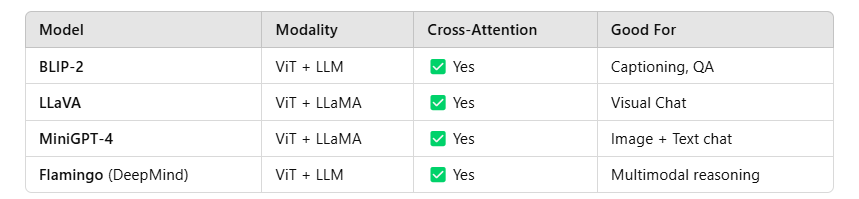



In [ ]:
# Refactored version of your model using BLIP-2 for image-text fusion

import torch
import torch.nn as nn
from transformers import Blip2Processor, Blip2Model
from torch.utils.data import Dataset, DataLoader

# ---------------------------
# BLIP-2 Feature Fusion Module
# ---------------------------
class BLIP2Fusion(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = Blip2Model.from_pretrained("Salesforce/blip2-opt-2.7b")
        self.processor = Blip2Processor.from_pretrained("Salesforce/blip2-opt-2.7b")

    def forward(self, image, text):
        inputs = self.processor(images=image, text=text, return_tensors="pt", padding=True).to(image.device)
        outputs = self.model(**inputs)
        # Take the CLS token or pooled output
        return outputs.last_hidden_state.mean(dim=1)  # [batch, hidden_dim]

# ---------------------------
# Regression Head
# ---------------------------
class KPIRegressor(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()
        self.regressor = nn.Sequential(
            nn.Linear(embed_dim, embed_dim // 2),
            nn.ReLU(),
            nn.Linear(embed_dim // 2, 1)
        )

    def forward(self, x):
        return self.regressor(x)

# ---------------------------
# Full Model with BLIP-2
# ---------------------------
class MultimodalRegressorBLIP2(nn.Module):
    def __init__(self, embed_dim=4096):  # Default for BLIP2-OPT-2.7B
        super().__init__()
        self.fusion = BLIP2Fusion()
        self.regressor = KPIRegressor(embed_dim)

    def forward(self, image, text):
        fused_features = self.fusion(image, text)
        return self.regressor(fused_features)

# ---------------------------
# Dummy Dataset Example
# ---------------------------
class DummyMultimodalDataset(Dataset):
    def __init__(self, num_samples=100):
        self.num_samples = num_samples
        self.images = [torch.rand(3, 224, 224) for _ in range(num_samples)]  # fake RGB images
        self.texts = ["This is a dummy caption." for _ in range(num_samples)]
        self.kpi_targets = torch.randn(num_samples, 1) * 100

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return {
            "image": self.images[idx],
            "text": self.texts[idx],
            "kpi": self.kpi_targets[idx]
        }

# ---------------------------
# Training Function
# ---------------------------
def train_model(model, dataloader, optimizer, criterion):
    model.train()
    total_loss = 0
    for batch in dataloader:
        image, text, kpi = batch["image"], batch["text"], batch["kpi"]
        image, kpi = image.cuda(), kpi.cuda()
        output = model(image, text)
        loss = criterion(output, kpi)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

# ---------------------------
# Main Execution
# ---------------------------
if __name__ == "__main__":
    train_dataset = DummyMultimodalDataset(20)
    train_loader = DataLoader(train_dataset, batch_size=2)

    model = MultimodalRegressorBLIP2().cuda()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
    criterion = nn.L1Loss()

    for epoch in range(3):
        loss = train_model(model, train_loader, optimizer, criterion)
        print(f"Epoch {epoch+1}, Loss: {loss:.4f}")
